# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [66]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    ups = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    cat = layers.concatenate([ups, large_ip_layer])
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(cat, filters)
    #output_layer = separable_conv2d_batchnorm(output_layer, filters)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [109]:
def showShape( mlayer, name = '' ) :
    print( name + ' : ', mlayer.get_shape().as_list() )

def fcn_model(inputs, num_classes):
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    enc1 = encoder_block(inputs, 70, 2)
    #enc1 = encoder_block(enc1, 20, 1)
    #pool1 = layers.MaxPooling2D()(enc1)

    enc2 = encoder_block(enc1, 70, 2)
    #enc3 = encoder_block(enc2, 32, 2)
    #pool2 = layers.MaxPooling2D()(enc2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv = conv2d_batchnorm(inputs, 3, kernel_size=1)
    #conv = layers.Dropout(0.8)(conv)
    showShape(conv, 'conv')
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    #x = layers.concatenate([enc3, pool2])
    #x = decoder_block(x, layers.concatenate([enc2, pool1]), 32)
    x = decoder_block(enc2, enc1, 70)
    x = decoder_block(x, conv, 70)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [110]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

conv :  [None, 160, 160, 3]


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [111]:
learning_rate = 0.0005
batch_size = 128
num_epochs = 50
decay_rate = learning_rate / num_epochs / 4
steps_per_epoch = 30
validation_steps = 7
workers = 2

Epoch 1/50
29/30 [============================>.] - ETA: 2s - loss: 1.1396

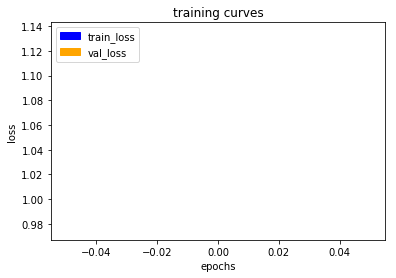

30/30 [==============================] - 68s - loss: 1.1350 - val_loss: 0.9751
Epoch 2/50
29/30 [============================>.] - ETA: 1s - loss: 0.9283

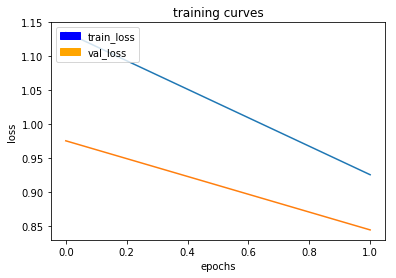

30/30 [==============================] - 64s - loss: 0.9260 - val_loss: 0.8439
Epoch 3/50
29/30 [============================>.] - ETA: 1s - loss: 0.7854

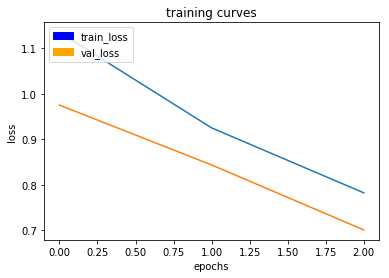

30/30 [==============================] - 64s - loss: 0.7830 - val_loss: 0.7012
Epoch 4/50
29/30 [============================>.] - ETA: 1s - loss: 0.6310

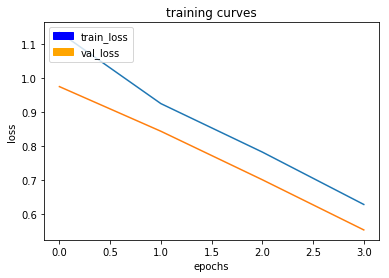

30/30 [==============================] - 64s - loss: 0.6284 - val_loss: 0.5537
Epoch 5/50
29/30 [============================>.] - ETA: 1s - loss: 0.4787

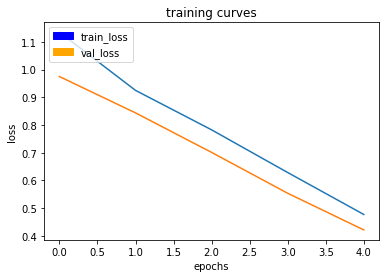

30/30 [==============================] - 63s - loss: 0.4764 - val_loss: 0.4214
Epoch 6/50
29/30 [============================>.] - ETA: 1s - loss: 0.3509

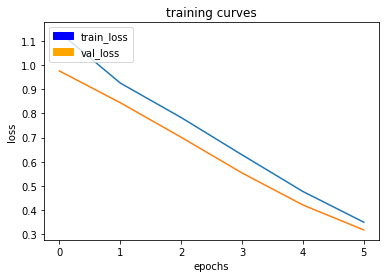

30/30 [==============================] - 64s - loss: 0.3492 - val_loss: 0.3183
Epoch 7/50
29/30 [============================>.] - ETA: 1s - loss: 0.2573

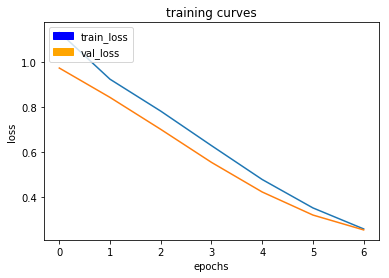

30/30 [==============================] - 64s - loss: 0.2563 - val_loss: 0.2519
Epoch 8/50
29/30 [============================>.] - ETA: 1s - loss: 0.1949

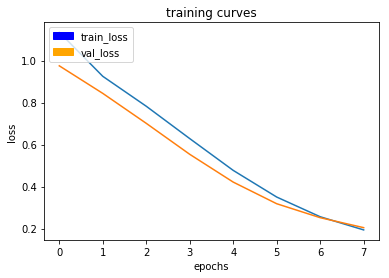

30/30 [==============================] - 65s - loss: 0.1939 - val_loss: 0.2044
Epoch 9/50
29/30 [============================>.] - ETA: 1s - loss: 0.1543

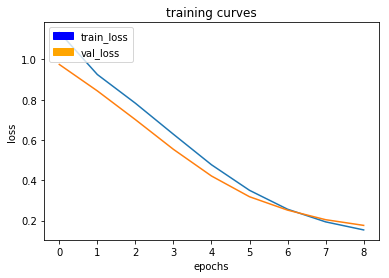

30/30 [==============================] - 63s - loss: 0.1537 - val_loss: 0.1762
Epoch 10/50
29/30 [============================>.] - ETA: 1s - loss: 0.1296

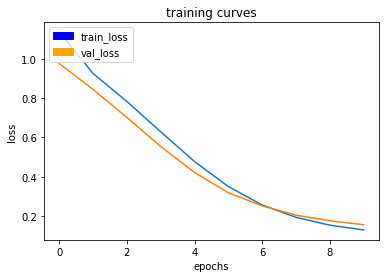

30/30 [==============================] - 64s - loss: 0.1297 - val_loss: 0.1558
Epoch 11/50
29/30 [============================>.] - ETA: 1s - loss: 0.1108

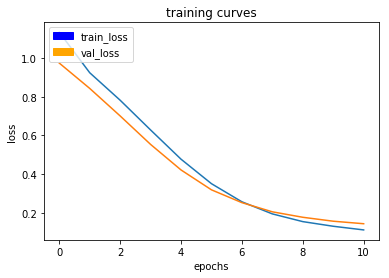

30/30 [==============================] - 64s - loss: 0.1105 - val_loss: 0.1427
Epoch 12/50
29/30 [============================>.] - ETA: 2s - loss: 0.0989

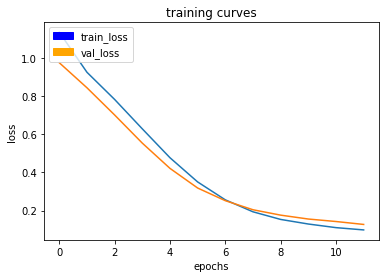

30/30 [==============================] - 64s - loss: 0.0985 - val_loss: 0.1274
Epoch 13/50
29/30 [============================>.] - ETA: 1s - loss: 0.0901

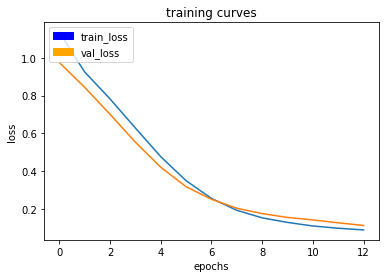

30/30 [==============================] - 65s - loss: 0.0899 - val_loss: 0.1134
Epoch 14/50
29/30 [============================>.] - ETA: 1s - loss: 0.0825

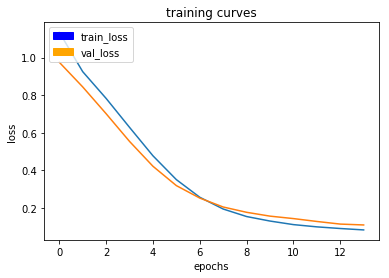

30/30 [==============================] - 63s - loss: 0.0823 - val_loss: 0.1088
Epoch 15/50
29/30 [============================>.] - ETA: 1s - loss: 0.0783

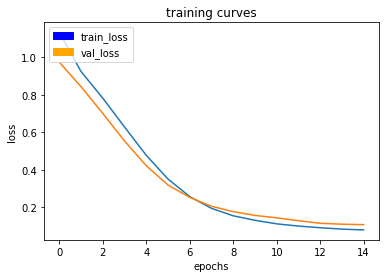

30/30 [==============================] - 64s - loss: 0.0781 - val_loss: 0.1064
Epoch 16/50
29/30 [============================>.] - ETA: 1s - loss: 0.0706

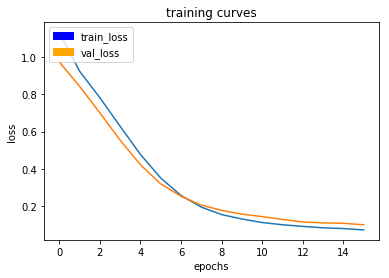

30/30 [==============================] - 63s - loss: 0.0708 - val_loss: 0.0987
Epoch 17/50
29/30 [============================>.] - ETA: 1s - loss: 0.0720

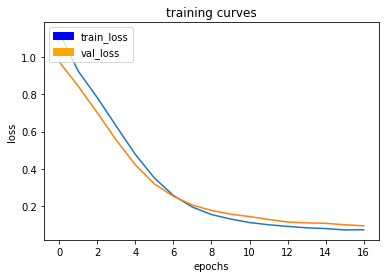

30/30 [==============================] - 64s - loss: 0.0719 - val_loss: 0.0928
Epoch 18/50
29/30 [============================>.] - ETA: 2s - loss: 0.0669

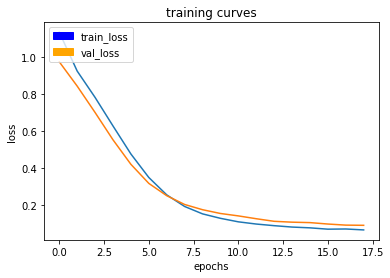

30/30 [==============================] - 64s - loss: 0.0670 - val_loss: 0.0918
Epoch 19/50
29/30 [============================>.] - ETA: 2s - loss: 0.0636

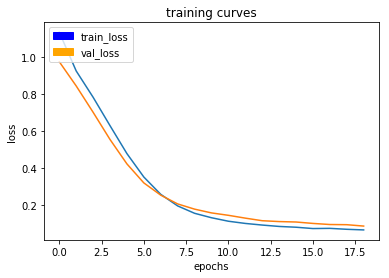

30/30 [==============================] - 66s - loss: 0.0636 - val_loss: 0.0844
Epoch 20/50
29/30 [============================>.] - ETA: 1s - loss: 0.0652

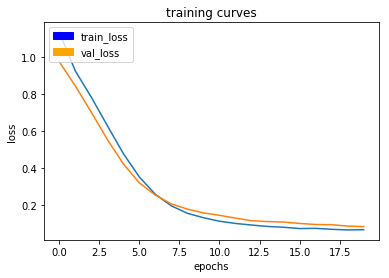

30/30 [==============================] - 63s - loss: 0.0651 - val_loss: 0.0814
Epoch 21/50
29/30 [============================>.] - ETA: 1s - loss: 0.0606

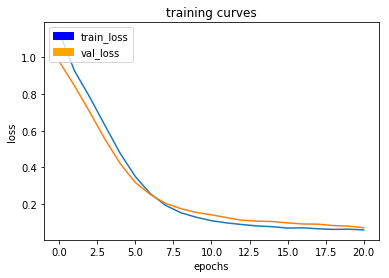

30/30 [==============================] - 63s - loss: 0.0605 - val_loss: 0.0722
Epoch 22/50
29/30 [============================>.] - ETA: 1s - loss: 0.0585

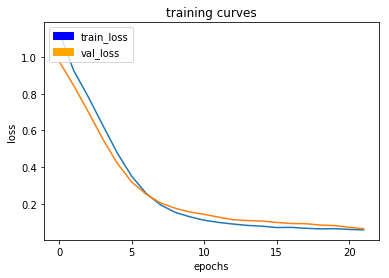

30/30 [==============================] - 63s - loss: 0.0581 - val_loss: 0.0642
Epoch 23/50
29/30 [============================>.] - ETA: 1s - loss: 0.0582

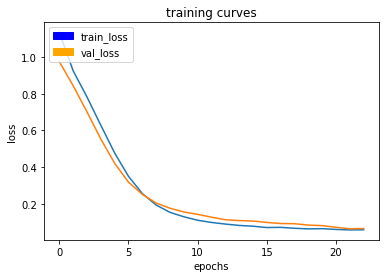

30/30 [==============================] - 64s - loss: 0.0584 - val_loss: 0.0654
Epoch 24/50
29/30 [============================>.] - ETA: 1s - loss: 0.0561

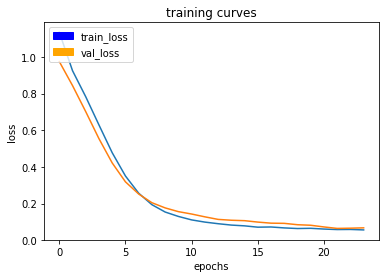

30/30 [==============================] - 63s - loss: 0.0559 - val_loss: 0.0673
Epoch 25/50
29/30 [============================>.] - ETA: 1s - loss: 0.0558

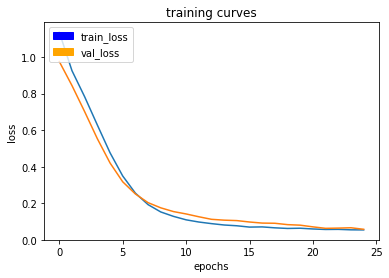

30/30 [==============================] - 65s - loss: 0.0555 - val_loss: 0.0590
Epoch 26/50
29/30 [============================>.] - ETA: 1s - loss: 0.0544

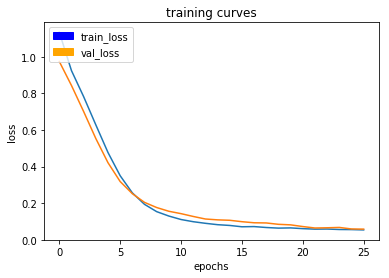

30/30 [==============================] - 63s - loss: 0.0542 - val_loss: 0.0581
Epoch 27/50
29/30 [============================>.] - ETA: 1s - loss: 0.0531

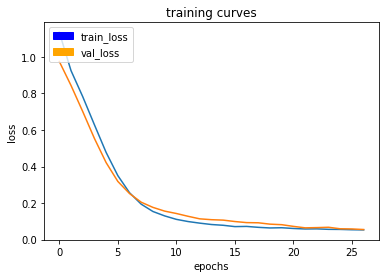

30/30 [==============================] - 64s - loss: 0.0530 - val_loss: 0.0549
Epoch 28/50
29/30 [============================>.] - ETA: 1s - loss: 0.0531

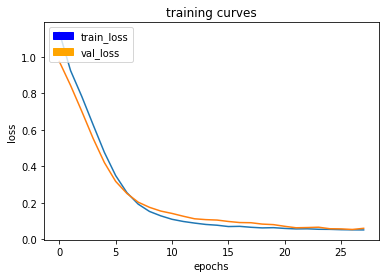

30/30 [==============================] - 63s - loss: 0.0529 - val_loss: 0.0612
Epoch 29/50
29/30 [============================>.] - ETA: 1s - loss: 0.0513

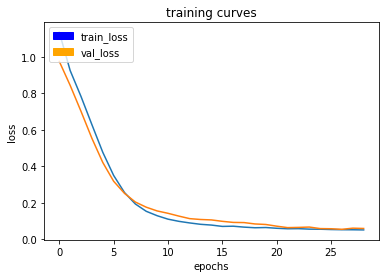

30/30 [==============================] - 64s - loss: 0.0518 - val_loss: 0.0596
Epoch 30/50
29/30 [============================>.] - ETA: 1s - loss: 0.0510

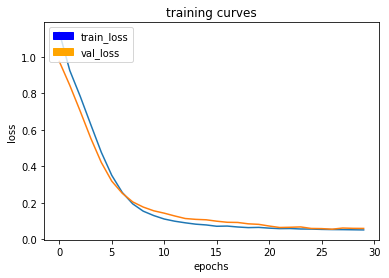

30/30 [==============================] - 64s - loss: 0.0508 - val_loss: 0.0590
Epoch 31/50
29/30 [============================>.] - ETA: 2s - loss: 0.0500

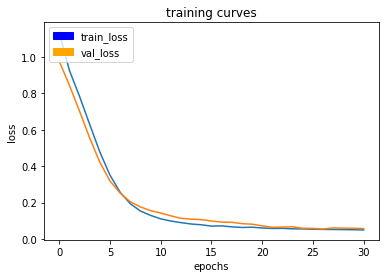


Epoch 00030: reducing learning rate to 0.0001500000071246177.
30/30 [==============================] - 65s - loss: 0.0500 - val_loss: 0.0573
Epoch 32/50
29/30 [============================>.] - ETA: 1s - loss: 0.0489

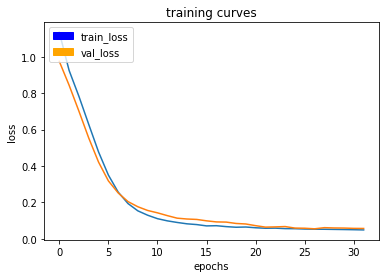

30/30 [==============================] - 64s - loss: 0.0486 - val_loss: 0.0568
Epoch 33/50
29/30 [============================>.] - ETA: 1s - loss: 0.0473

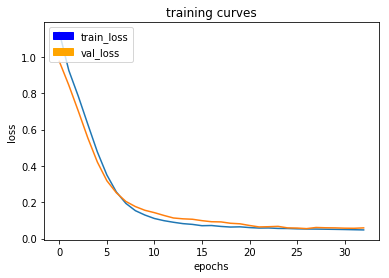

30/30 [==============================] - 63s - loss: 0.0479 - val_loss: 0.0590
Epoch 34/50
29/30 [============================>.] - ETA: 1s - loss: 0.0490

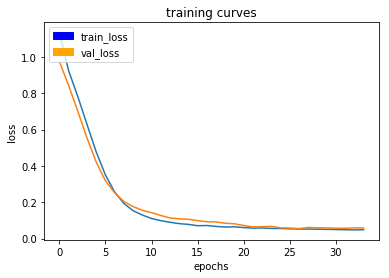


Epoch 00033: reducing learning rate to 4.500000213738531e-05.
30/30 [==============================] - 64s - loss: 0.0490 - val_loss: 0.0586
Epoch 35/50
29/30 [============================>.] - ETA: 1s - loss: 0.0475

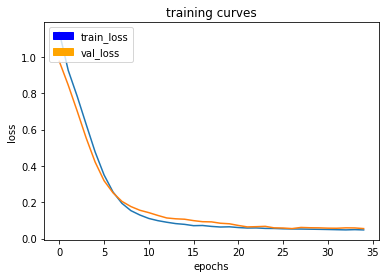

30/30 [==============================] - 63s - loss: 0.0475 - val_loss: 0.0549
Epoch 36/50
29/30 [============================>.] - ETA: 1s - loss: 0.0477

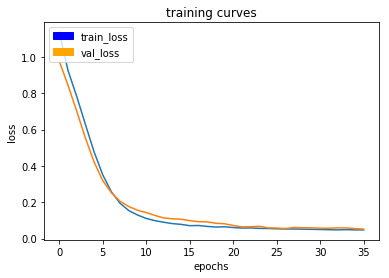

30/30 [==============================] - 64s - loss: 0.0478 - val_loss: 0.0519
Epoch 37/50
29/30 [============================>.] - ETA: 1s - loss: 0.0480

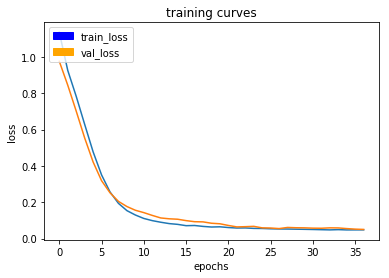

30/30 [==============================] - 64s - loss: 0.0479 - val_loss: 0.0503
Epoch 38/50
29/30 [============================>.] - ETA: 1s - loss: 0.0480

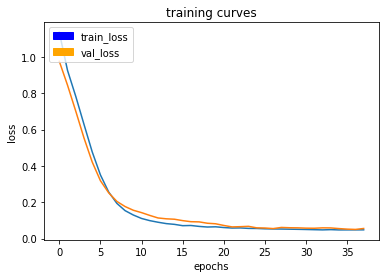

30/30 [==============================] - 65s - loss: 0.0481 - val_loss: 0.0555
Epoch 39/50
29/30 [============================>.] - ETA: 1s - loss: 0.0463

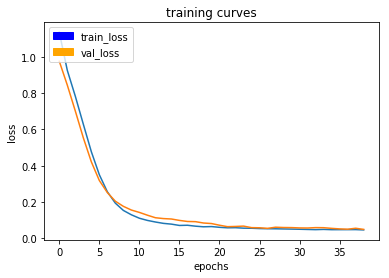

30/30 [==============================] - 64s - loss: 0.0462 - val_loss: 0.0492
Epoch 40/50
29/30 [============================>.] - ETA: 1s - loss: 0.0487

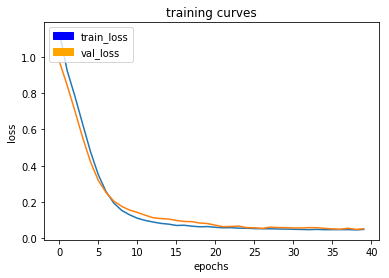

30/30 [==============================] - 64s - loss: 0.0490 - val_loss: 0.0528
Epoch 41/50
29/30 [============================>.] - ETA: 1s - loss: 0.0475

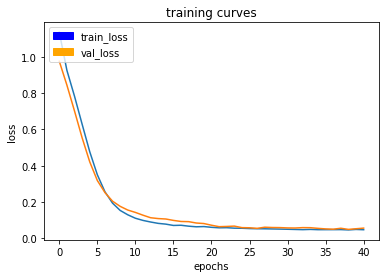

30/30 [==============================] - 64s - loss: 0.0473 - val_loss: 0.0562
Epoch 42/50
29/30 [============================>.] - ETA: 1s - loss: 0.0478

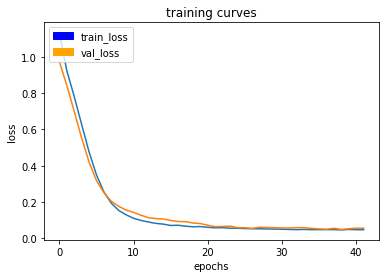

30/30 [==============================] - 64s - loss: 0.0477 - val_loss: 0.0556
Epoch 43/50
29/30 [============================>.] - ETA: 1s - loss: 0.0471

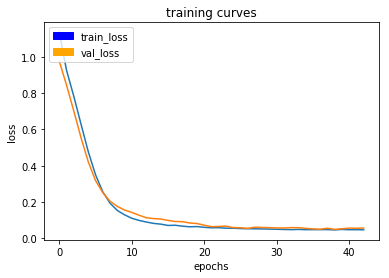


Epoch 00042: reducing learning rate to 1.3500000204658135e-05.
30/30 [==============================] - 64s - loss: 0.0469 - val_loss: 0.0565
Epoch 44/50
29/30 [============================>.] - ETA: 1s - loss: 0.0479

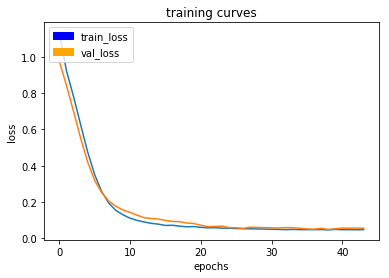

30/30 [==============================] - 65s - loss: 0.0479 - val_loss: 0.0558
Epoch 45/50
29/30 [============================>.] - ETA: 1s - loss: 0.0473

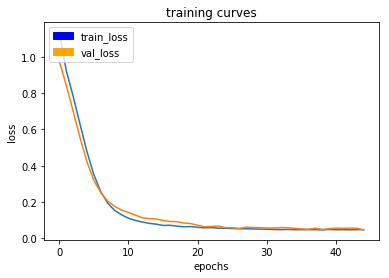

30/30 [==============================] - 64s - loss: 0.0474 - val_loss: 0.0465
Epoch 46/50
29/30 [============================>.] - ETA: 1s - loss: 0.0477

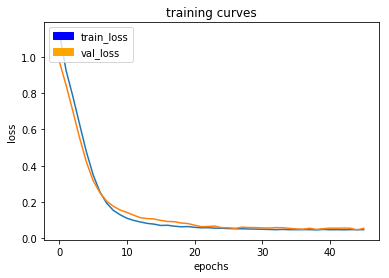

30/30 [==============================] - 64s - loss: 0.0477 - val_loss: 0.0549
Epoch 47/50
29/30 [============================>.] - ETA: 1s - loss: 0.0468

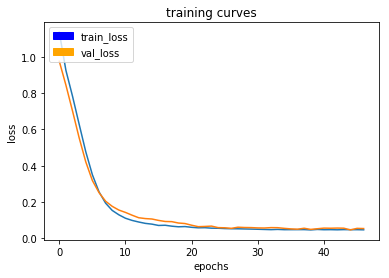

30/30 [==============================] - 63s - loss: 0.0467 - val_loss: 0.0539
Epoch 48/50
29/30 [============================>.] - ETA: 1s - loss: 0.0470

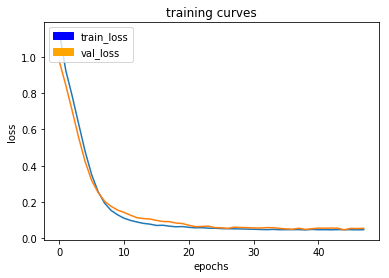

30/30 [==============================] - 64s - loss: 0.0481 - val_loss: 0.0553
Epoch 49/50
29/30 [============================>.] - ETA: 1s - loss: 0.0466

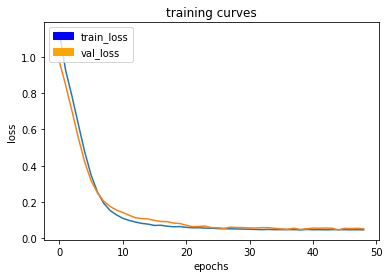


Epoch 00048: reducing learning rate to 4.050000006827758e-06.
30/30 [==============================] - 64s - loss: 0.0465 - val_loss: 0.0531
Epoch 50/50
29/30 [============================>.] - ETA: 1s - loss: 0.0479

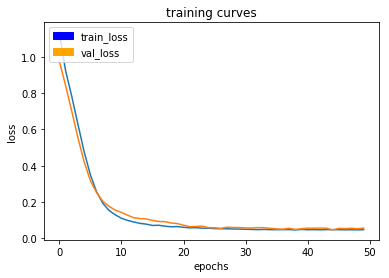

30/30 [==============================] - 64s - loss: 0.0478 - val_loss: 0.0562


In [113]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

from workspace_utils import active_session
# Keeping Your Session Active
with active_session():
    # Define the Keras model and compile it for training
    model = models.Model(inputs=inputs, outputs=output_layer)

    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate, decay=decay_rate), loss='categorical_crossentropy')

    # Data iterators for loading the training and validation data
    train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                   data_folder=os.path.join('..', 'data', 'train'),
                                                   image_shape=image_shape,
                                                   shift_aug=True)

    val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                 data_folder=os.path.join('..', 'data', 'validation'),
                                                 image_shape=image_shape)

    callbacks = []
    callbacks.append(plotting_tools.LoggerPlotter())
    callbacks.append(EarlyStopping(monitor='val_loss', patience=10))
    callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1))

    model.fit_generator(train_iter,
                        steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                        epochs = num_epochs, # the number of epochs to train for,
                        validation_data = val_iter, # validation iterator
                        validation_steps = validation_steps, # the number of batches to validate on
                        callbacks=callbacks,
                        workers = workers)

In [114]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [14]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights'
model = model_tools.load_network(weight_file_name)


The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [115]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

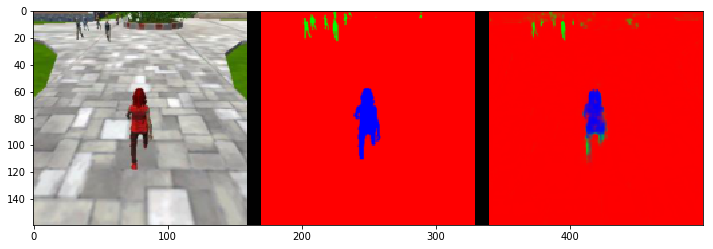

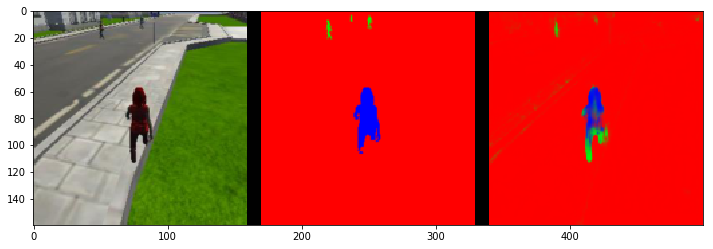

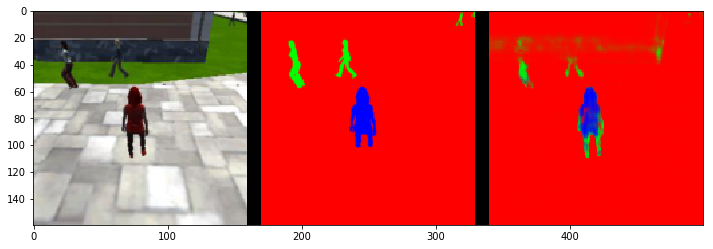

In [116]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

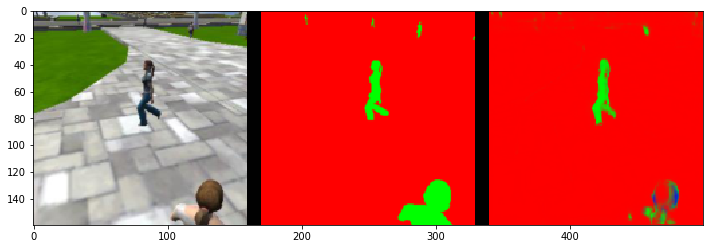

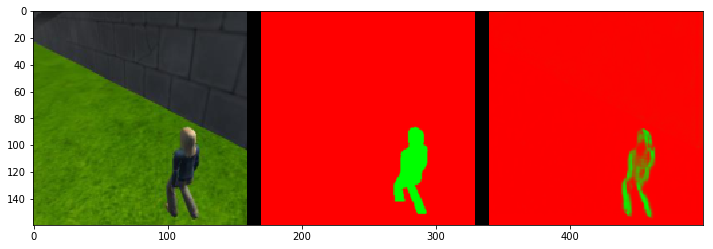

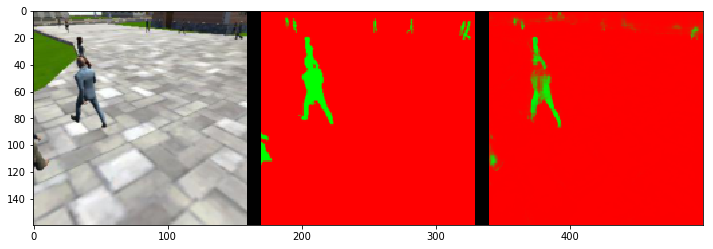

In [117]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

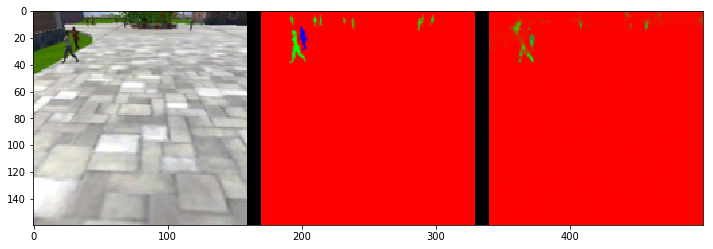

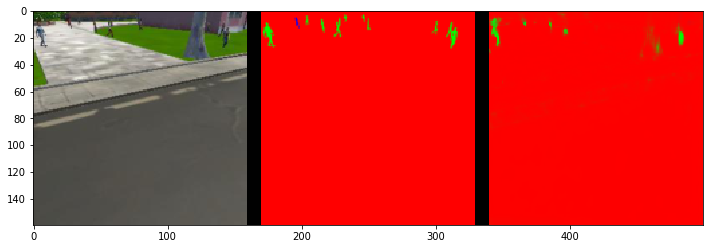

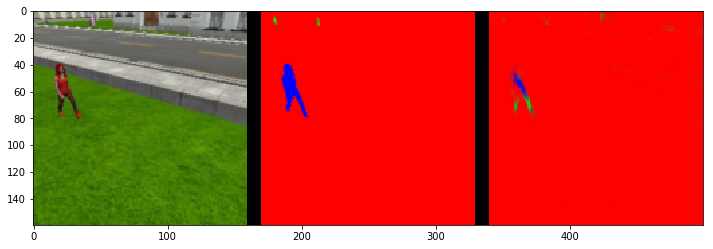

In [118]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [119]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9877731138754449
average intersection over union for other people is 0.13886844434502987
average intersection over union for the hero is 0.4763031452271231
number true positives: 539, number false positives: 0, number false negatives: 0


In [120]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9708557984556803
average intersection over union for other people is 0.36677849295144205
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 88, number false negatives: 0


In [121]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9934559959810617
average intersection over union for other people is 0.23675957865327993
average intersection over union for the hero is 0.05653045149684889
number true positives: 84, number false positives: 4, number false negatives: 217


In [122]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.6684549356223176


In [123]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.266416798362


In [124]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.178087623798
